## COMPIM Project
# Download and visualize the ICVL dataset

**Authors:** Achraf Jenzri, Hamdi Sghir, Nassim Ladhar, Selman Sezgin

In [5]:
import logging
import os
import subprocess
import torch
import h5py
import numpy as np
import urllib.request
import glob
import matplotlib.pyplot as plt
import json

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [15]:
Output_Dir = './Data/'

In [7]:
with open('icvl_split.json', 'r') as f:
    # Load the contents of the file as a dictionary
    split = json.load(f)

In [12]:
# utils functions
def check_filesize(target, url):
  # check size of a file from a url and verify if it can be loaded
    try:
        filesize = os.path.getsize(target)
    except FileNotFoundError:
        return False
    target_filesize = urllib.request.urlopen(url).length
    return filesize == target_filesize


def touch(path):
    # create file
    with open(path, "w") as f:
        f.write("")


In [17]:
# Function that downloads ICVL data 
def download(path_data):
    BASE_URL = "http://icvl.cs.bgu.ac.il/img/hs_pub/"
    path_dataset = os.path.join(path_data, "ICVL")
    path_raw = os.path.join(path_dataset, "raw")
    path_dl_complete = os.path.join(path_raw, ".download_complete")
    if os.path.exists(path_dl_complete):
        logger.info(f"Dataset downloaded")
        return
    logger.info(f"{path_dl_complete!r} not found, checking filesizes ..")
    os.makedirs(path_raw, exist_ok=True)

    icvl_all = list(split['icvl_train']) + list(split['icvl_val']) + list(split['icvl_test'])
    icvl_all = [f"{fn}.mat" for fn in icvl_all]
    for i, filename in enumerate(icvl_all[:2]):  # Just two to test !!
        target = os.path.join(path_raw, filename)
        url = os.path.join(BASE_URL, filename)
        logger.info(
            f"Checking image ({i + 1}/{len(icvl_all)}) : {filename}"
        )
        if os.path.exists(target) and check_filesize(target, url):
            logger.info(f"OK")
            continue
        logger.info(f"Downloading..")
        subprocess.check_call(
            f"wget {url} -O \"{target}\"",
            shell=True,
            stdout=subprocess.DEVNULL,
        )

    touch(path_dl_complete)

In [18]:
download(Output_Dir)

INFO:__main__:'./Data/ICVL/raw/.download_complete' not found, checking filesizes ..
INFO:__main__:Checking image (1/152) : 4cam_0411-1640-1.mat
INFO:__main__:Downloading..
INFO:__main__:Checking image (2/152) : BGU_0522-1127.mat
INFO:__main__:Downloading..


In [19]:
# Normalization classes for the preprocessing
class BaseNormalizer:
    def __init__(self):
        assert hasattr(self, "STATEFUL"), "Missing STATEFUL class attribute"

    def fit(self, x):
        raise NotImplementedError

    def transform(self, x):
        raise NotImplementedError

    def get_id(self):
        attributes = [self.__class__.__name__]
        attributes += [
            k[:3] + str(v)
            for k, v in self.__dict__.items()
            if not isinstance(v, torch.Tensor)
        ]
        return "_".join(attributes).replace(".", "")

    def __repr__(self):
        return self.get_id()

    def filename(self):
        return f"{self.get_id()}.pth"

    def save(self, path=None):
        filename = self.filename()
        if path:
            filename = os.path.join(path, filename)
        torch.save(self.__dict__, filename)
        logger.info(f"Normalizer {self} saved to {filename!r}")

    def load(self, path=None):
        filename = self.filename()
        if path:
            filename = os.path.join(path, filename)
        logger.info(f"Loading normalizer {self} from {filename!r}")
        state = torch.load(filename)
        for k, v in state.items():
            setattr(self, k, v)


class GlobalMinMax(BaseNormalizer):
    STATEFUL = False

    def __init__(self, epsilon=0.001):
        super().__init__()
        self.epsilon = epsilon

    def transform(self, x):
        mi = torch.amin(x, dim=(0, 1, 2), keepdim=True)
        ma = torch.amax(x, dim=(0, 1, 2), keepdim=True)
        return (x - mi) / (self.epsilon + (ma - mi))

In [21]:
# Preprocessing function
def preprocess(path_data):
    path_source = os.path.join(path_data, "ICVL", "raw")
    path_dest = os.path.join(path_data,"ICVL" , "clean")
    path_complete = os.path.join(path_dest, ".complete")
    if os.path.exists(path_complete):
        return

    os.makedirs(path_dest, exist_ok=True)

    normalizer = GlobalMinMax()
    icvl_all = sorted(glob.glob(path_source + '/*.mat')) 
    icvl_all = [file.split('/')[-1] for file in icvl_all]
    for i, fn in enumerate(icvl_all):
        fn, suffix = os.path.splitext(fn)
        path_out = os.path.join(path_dest, f"{fn}.pth")
        if os.path.exists(path_out):
            continue
        logger.info(f"Preprocessing {fn}")
        path_in = os.path.join(path_source, f"{fn}.mat")
        with h5py.File(path_in, "r") as f:
            img = np.array(f["rad"], dtype=np.float32)
        img_torch = torch.tensor(img, dtype=torch.float32)
        img_torch = normalizer.transform(img_torch).clone()
        logger.info(f"shape : {tuple(img_torch.shape)} ")

        torch.save(img_torch, path_out)
        logger.info(
            f"Saved normalized image {i + 1}/{len(icvl_all)} "
            f"to {path_out}"
        )
    touch(path_complete)
    logger.info(f"Dataset preprocessed")


In [22]:
preprocess(Output_Dir)

INFO:__main__:Preprocessing 4cam_0411-1640-1
INFO:__main__:shape : (31, 1392, 1300) 
INFO:__main__:Saved normalized image 1/2 to ./Data/ICVL/clean/4cam_0411-1640-1.pth
INFO:__main__:Preprocessing BGU_0522-1127
INFO:__main__:shape : (31, 1392, 1300) 
INFO:__main__:Saved normalized image 2/2 to ./Data/ICVL/clean/BGU_0522-1127.pth
INFO:__main__:Dataset preprocessed


In [23]:
mat_all = glob.glob(Output_Dir + '/ICVL/raw/*.mat')
pth_all = glob.glob(Output_Dir + '/ICVL/clean/*.pth')

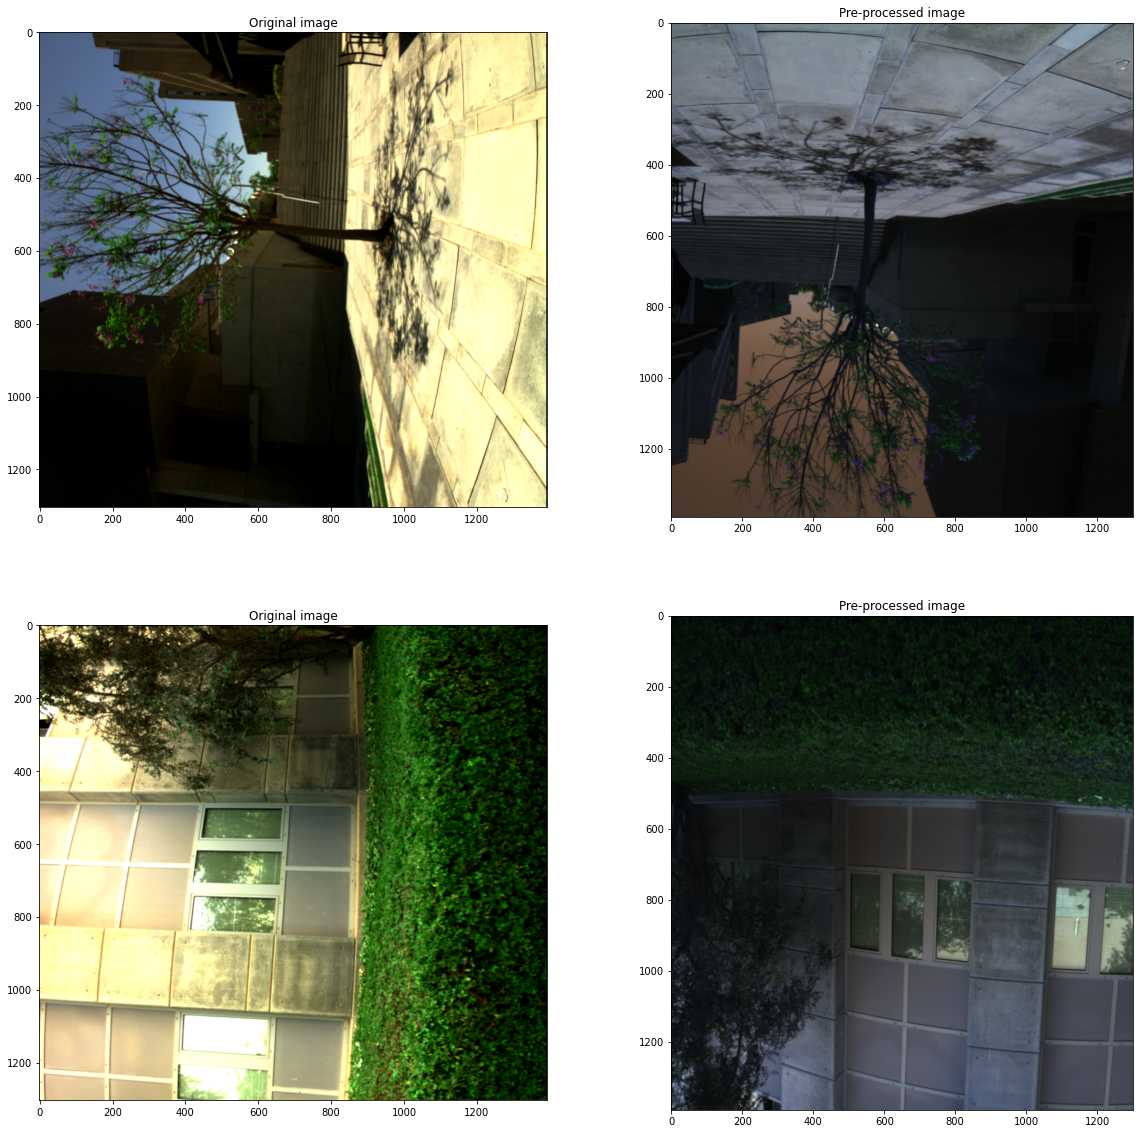

In [39]:
# Visualization
fig, axs = plt.subplots(len(mat_all), 2, figsize=(20, 20))
for i in range(len(mat_all)):
  f = h5py.File(mat_all[i])
  img_raw = np.transpose(f['rgb'], (1, 2, 0))
  axs[i,0].imshow(img_raw)
  axs[i,0].set_title('Original image')

  x = torch.load(pth_all[i]).numpy()
  img_clean = np.transpose(x[[8, 14, 27], :], (1, 2, 0))
  axs[i,1].imshow(img_clean)
  axs[i,1].set_title('Pre-processed image')
plt.show()